In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils_notebook import *


from typing import Dict


/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TODO: resolve the following issue https://discuss.pytorch.org/t/getting-nan-value-only-on-cpu/73696/8

In [2]:
# torch.set_default_dtype(torch.float64)
torch.cuda.is_available()

True

In [4]:
DATA = 'cifar100'
LIKELIHOOD = 'softmax'
EPOCH = 269
# MODELS = ['models_repl', 'models_mono_weights', 'models_mono_weights_5', 'models_mono_penal', 'models_mono_penal_stop_grad', 'models_poe_cascade_stop_grad']

# MODELS = ['models_repl', 'models_mono_weights', 'models_mono_weights_5']
# MODELS_NAMES = ['base', 'mono-weights C=1', 'mono-weights C=5']

# MODELS = ['models_repl', 'models_mono_penal', 'models_mono_penal_stop_grad', 'models_mono_penal_3', 'models_mono_penal_5']
# MODELS_NAMES = ['base', 'mono-constr-opt C=1', 'mono-constr-opt C=1 w. stop-grad', 'mono-constr-opt C=3', 'mono-constr-opt C=5']

# MODELS = ['models_repl', 'models_poe_cascade_repl', 'models_poe_cascade_stop_grad']
# MODELS_NAMES = ['base', 'PoE-softmax-cascade', 'PoE-softmax-cascade w. stop-grad']

MODELS = ['models_repl', 'models_mono_penal_1_fix','models_mono_penal_stop_grad_fix', 'models_mono_penal_3_fix', 'models_mono_penal_3_stop_grad_fix']
MODELS_NAMES = ['base', 'mono-constr-opt C=1', 'mono-constr-opt C=1 w. stop-grad', 'mono-constr-opt C=3', 'mono-constr-opt C=3 w. stop-grad']


logits_dict = {}
for model_name in MODELS:
    _logits, targets, _ = get_logits_targets(DATA, model_name, LIKELIHOOD, EPOCH, cuda=True, logits_type='test')
    logits_dict[model_name] = _logits

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [7]:
# PROBS_TYPE = 'BASE'
PROBS_TYPE = 'PoE'
# PROBS_TYPE = 'PoE-OvR'

acc_dict, mono_dict, forget_dict = {}, {}, {}
for model_name in MODELS:
    logits = logits_dict[model_name]

    L = len(logits)
    N = len(targets)

    if PROBS_TYPE == 'PoE':
        logits = logits.cumsum(dim=0) / torch.tensor([1., 2., 3., 4., 5., 6., 7.])[:, None, None]
        probs = torch.softmax(logits, dim=2)
    elif PROBS_TYPE == 'PoE-OvR':
        T = 1.
        probs = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
    elif PROBS_TYPE == 'BASE':
        probs = torch.softmax(logits, dim=2)

    preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
    acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]

    mono_modal_prob = [round(x, 4) for x in modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]
    mono_y_star = [round(x, 4) for x in modal_probs_decreasing(targets, probs, layer=None, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]
    forget_arr = measure_forgetting(preds, targets, L, N)

    print('Model:', model_name)
    print([round(float(x), 4) for x in acc])
    print(mono_modal_prob)
    print(mono_y_star)
    print(forget_arr)

    acc_dict[model_name] = acc
    mono_dict[model_name] = modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all")
    forget_dict[model_name] = forget_arr

Model: models_repl
[0.6334, 0.6852, 0.7083, 0.7233, 0.7368, 0.744, 0.7483]
[65.75, 45.2, 31.37, 22.75, 13.02, 9.8, 6.27, 1.68]
[66.64, 42.07, 28.05, 20.51, 12.97, 10.29, 7.28, 3.3]
[2.39, 2.97, 1.31, 0.83, 0.69, 0.64]
Model: models_mono_penal_1_fix
[0.5833, 0.6557, 0.6977, 0.7176, 0.7282, 0.7335, 0.7389]
[56.55, 46.97, 32.69, 21.92, 9.72, 6.33, 3.07, 0.45]
[60.47, 48.46, 33.47, 23.77, 12.79, 9.34, 5.98, 1.79]
[0.96, 1.02, 4.130000000000001, 1.4000000000000001, 1.8800000000000001, 3.05]
Model: models_mono_penal_stop_grad_fix
[0.5922, 0.6714, 0.7118, 0.7287, 0.7384, 0.7465, 0.7507]
[55.56, 40.69, 29.81, 22.94, 14.24, 10.91, 7.04, 2.43]
[57.15, 39.2, 28.0, 21.68, 14.59, 11.79, 8.93, 4.91]
[1.78, 0.73, 3.53, 2.65, 0.7000000000000001, 1.06]
Model: models_mono_penal_3_fix
[0.4725, 0.6069, 0.6658, 0.6999, 0.7211, 0.7381, 0.7454]
[38.68, 33.67, 19.71, 9.17, 1.94, 0.78, 0.16, 0.0]
[46.02, 40.19, 26.45, 16.14, 5.98, 3.4, 1.52, 0.21]
[3.8600000000000003, 1.66, 2.45, 4.19, 1.28, 1.38]
Model: model

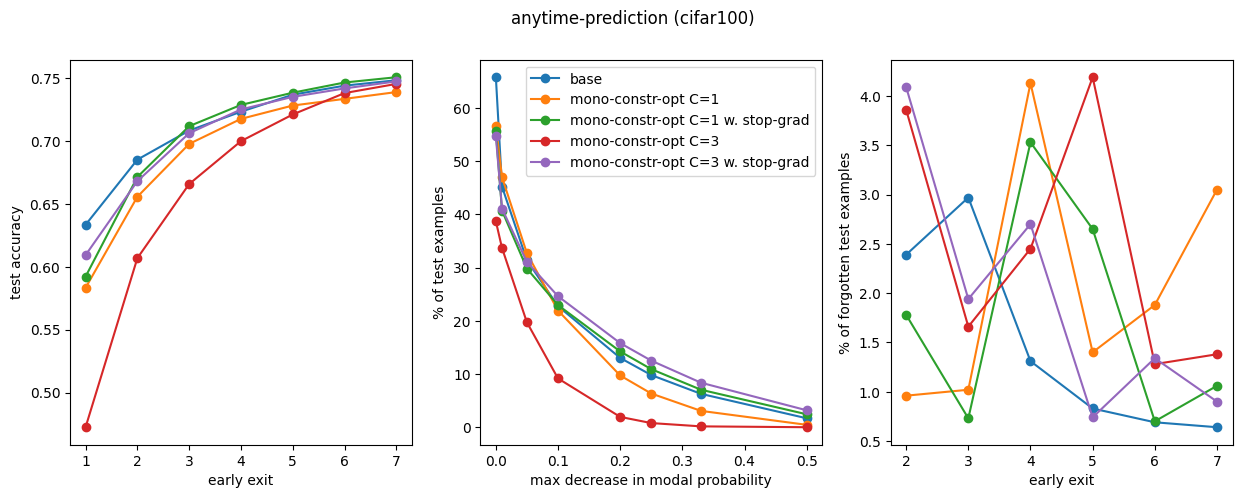

In [8]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for model_name, model_label in zip(MODELS, MODELS_NAMES):
    ax[0].plot(early_exits, acc_dict[model_name], label=model_label, marker='o',)
    ax[1].plot(mono_dict[model_name].keys(), mono_dict[model_name].values(), marker='o', label=model_label)
    ax[2].plot(early_exits[1:], forget_dict[model_name], marker='o', label=model_label)

ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit') 
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples') 
ax[2].set_xlabel('early exit')
ax[2].set_ylabel('% of forgotten test examples')
ax[1].legend()

plt.suptitle(f'anytime-prediction ({DATA})')
plt.show()
